# Accuracy of Schrödinger equation 
Compare accuracy of FFT, Chebyshev & Gram-Fourier extension spectral methods with finite difference methods for evolving the linear Schrödinger equation

In [84]:

import numpy as np
import scipy.fft


class FFTSolver:
    """
    A class to solve the Schrödinger equation using the FFT spectral method.

    Parameters:
        t0 (float): The initial time.
        t_end (float): The final time for simulation.
        cfl (float): The CFL condition number.
        resolution (int): The number of spatial points.
        domain_size (tuple): The physical domain size as (l0, l1).
        hbar (float): Reduced Planck's constant.
        m (float): Mass.
        n_threads (int): Number of threads for FFT computations.
        generate_ic (function): A function to generate initial conditions.
    """
    def __init__(self, t0, cfl, resolution, domain_size, hbar, m, generate_ic):
        self.t = t0
        self.cfl = cfl
        self.n_physical = resolution
        self.l0_physical, self.l1_physical = domain_size
        self.hbar = hbar
        self.m = m
        self.eta = self.hbar / self.m
        self.generate_ic = generate_ic

        # Compute spatial grid parameters
        self.width_physical = self.l1_physical - self.l0_physical
        self.dx = self.width_physical / self.n_physical
        self.x_lin = np.arange(self.n_physical) * self.dx + self.l0_physical

        # Initialize psi with the initial condition
        self.psi = self.generate_ic(self.x_lin, self.dx, self.t, self.m, self.hbar)
        self.potential = np.zeros_like(self.psi)

        # Setup Fourier space variables

        n = np.arange(-self.n_physical/2, self.n_physical/2)
        k = 2 * np.pi / self.width_physical * n
        k = np.fft.ifftshift(k)
        self.k_sq = np.fft.fftshift(k)**2

    def get_time_step(self):
        """Calculate and return the time step based on the CFL condition."""
        return self.cfl * self.dx**2 / self.eta

    def step(self, dt):
        """Perform a single time step."""
        # Half kick
        self.psi *= np.exp(-1.0j * dt / 2 * self.potential)
        # Drift
        psihat   = scipy.fft.fftn(self.psi)
        psihat   = np.exp(dt * (-1.0j * self.eta * self.k_sq / 2.0)) * psihat
        self.psi = scipy.fft.ifftn(psihat)
        # Half kick
        self.psi *= np.exp(-1.0j * dt / 2 * self.potential)
        self.t   += dt

    def run(self, t_end):
        """Run the simulation until the specified final time."""
        i = 0
        while self.t < t_end - 1e-15:
            dt = self.get_time_step()
            if t_end - self.t < dt:
                dt = t_end - self.t
            self.step(dt)
            i += 1
        print(f"Finished in {i} time steps at t = {self.t}")


In [116]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot(scheme): 
    psi            = scheme.psi 
    psi_analytical = scheme.generate_ic(scheme.x_lin, scheme.dx, scheme.t, scheme.m, scheme.hbar)

    # Compute density and phase
    density = np.abs(psi)**2
    phase   = np.angle(psi)
    density_analytical = np.abs(psi_analytical)**2
    phase_analytical   = np.angle(psi_analytical)

    L1      = np.sum(np.abs(np.abs(psi)**2 - np.abs(psi_analytical)**2))

    # Compute RMS
    rms = 0

    # Setting up Seaborn for aesthetics
    sns.set(style="whitegrid")

    # Creating subplots
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plotting density
    sns.lineplot(data=density, lw = 2, ax=axs[0])
    sns.lineplot(data=density_analytical, ax=axs[0])
    axs[0].set_title("Density")
    axs[0].set_xlabel("Position")
    axs[0].set_ylabel("Density")

    # Plotting phase
    sns.lineplot(data=phase, lw = 2, ax=axs[1])
    sns.lineplot(data=phase_analytical, ax=axs[1])
    axs[1].set_title("Phase")
    axs[1].set_xlabel("Position")
    axs[1].set_ylabel("Phase")

    # Setting the main title with current time and RMS
    plt.suptitle(f"Time: {scheme.t:.2f}, $L_1$: {L1:.2e}")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the main title
    plt.show()


In [118]:

def generate_plane_wave(x, dx, t, m=1, hbar=1, k=1):
    """
    Generates a plane wave solution for the 1D free Schrödinger equation.

    Parameters:
        x (array): The spatial grid points.
        dx (float): The spatial resolution.
        t (float): The time.
        m (float, optional): The mass. Defaults to 1.
        hbar (float, optional): Reduced Planck's constant. Defaults to 1.
        k (float, optional): The wave number. Defaults to 1.

    Returns:
        array: The plane wave solution at the given time and position.
    """
    omega = hbar / (2 * m) * k**2
    return np.exp(1j * (k * x - omega * t))


fft_solver = FFTSolver(t0=0, cfl=0.1, resolution=32, domain_size=(0, 2*np.pi), hbar=1, m=1,  generate_ic=generate_plane_wave)
fft_solver.run(1)

Finished in 260 time steps at t = 1.0


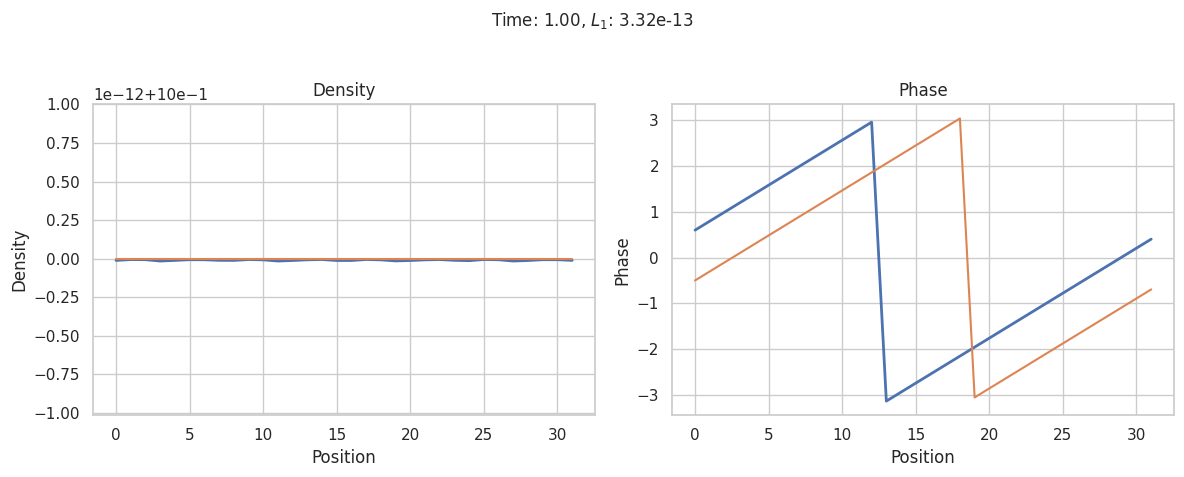

In [119]:
plot(fft_solver)

In [126]:

def generate_standing_gaussian(x0, x, t, m=1, hbar=1, alpha=1.0 / 10):
    """
    Generates a standing Gaussian wave solution for the 1D free Schrödinger equation.

    Parameters:
        x0 (float): The initial position of the wave packet.
        x (array): The spatial grid points.
        t (float): The time.
        m (float, optional): The mass. Defaults to 1.
        hbar (float, optional): Reduced Planck's constant. Defaults to 1.
        alpha (float, optional): The width parameter of the Gaussian. Defaults to 0.1.

    Returns:
        array: The standing Gaussian wave solution at the given time and position.
    """
    psi = np.sqrt(1 / (alpha + 1.0j * t * hbar / m)) * np.exp(
        -((x - x0) ** 2) / (2 * (alpha + 1.0j * t * hbar / m))
    )
    return psi

def generate_periodic_standing_gaussian(x, dx, t, m=1, hbar=1, x0=5, alpha=1/20, eps=0, L=10, N=100):
    """
    Generates a periodic standing Gaussian wave solution for the 1D free Schrödinger equation.

    Parameters:
        x (array): The spatial grid points.
        dx (float): The spatial resolution.
        t (float): The time.
        m (float, optional): The mass. Defaults to 1.
        hbar (float, optional): Reduced Planck's constant. Defaults to 1.
        x0 (float, optional): The initial position of the wave packet. Defaults to 5.
        alpha (float, optional): The width parameter of the Gaussian. Defaults to 0.05.
        eps (float, optional): A smal0_total constant to ensure numerical stability. Defaults to 0.
        L (float, optional): The periodicity length. Defaults to 10.
        N (int, optional): The number of periods to simulate. Defaults to 100.

    Returns:
        array: The periodic standing Gaussian wave solution at the given time and position.
    """
    psi = eps + 0j
    for i in range(-N, N + 1):
        psi += generate_standing_gaussian(x0, x + L * i, t, m, hbar, alpha)
    return psi


fft_solver = FFTSolver(t0=0, cfl=0.1, resolution=1024, domain_size=(0, 10), hbar=1, m=1,  generate_ic=generate_periodic_standing_gaussian)
fft_solver.step(1e-8)


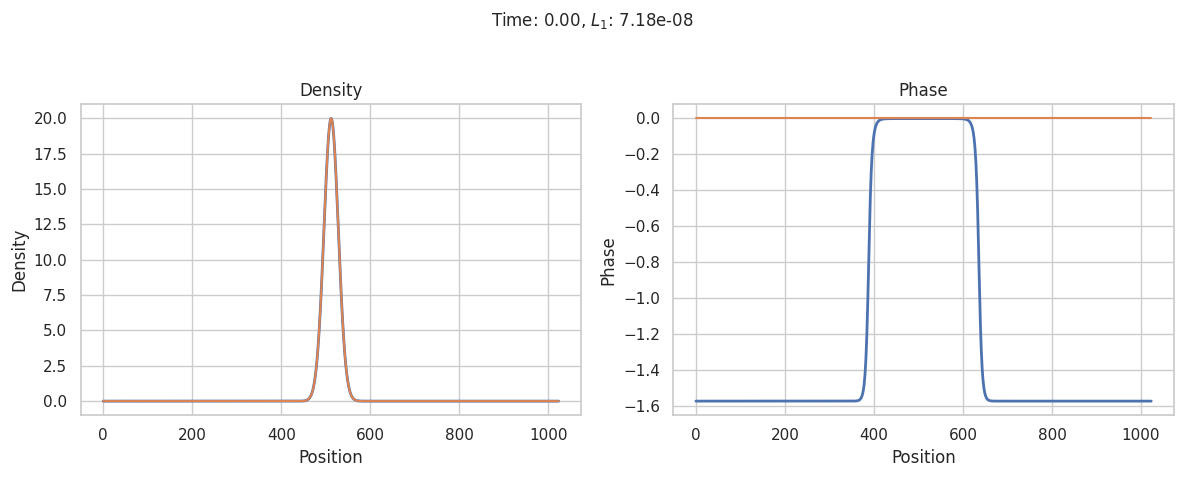

In [127]:
plot(fft_solver)

In [ ]:

class GramExtensionScheme(Scheme):
    def __init__(self, config, generate_ic):
        super().__init__(config, generate_ic)
        self.Gamma  = config["extensionGamma"]
        self.g      = config["extensionG"]
        self.nDelta = config["extensionNDelta"]
        self.nd     = config["extensionND"]
        self.mreal    = config["realPrecision"]
        self.mcomplex   = config["complexPrecision"]
        self.minput   = config["inputPrecision"]

        Gamma, g, nD, nd = self.Gamma, self.g, self.nDelta, self.nd

        self.F = np.fromfile(f"nD={nD}_nd={nd}_g={g}_Gamma={Gamma}.bin").reshape(nD * 2, 2 * nD + 2 * nd - 4)
        self.Fe = self.F[:nD, :].astype(self.mreal)
        self.Fo = self.F[nD:, :].astype(self.mreal)
        self.Pl = np.fromfile(f"Pleft_nD={nD}.bin").reshape( nD, nD).astype(self.mreal)
        self.Pr = np.fromfile(f"Pright_nD={nD}.bin").reshape(nD, nD).astype(self.mreal)

        self.proj   = config.get("projectionOrder", 5)
        self.psi    = self.generate_ic(*self.grid, self.dx, self.t, self.m, self.hbar).astype(self.mcomplex)
        self.fields = self.psi.astype(self.mcomplex)
        self.counter = 0
        self.alpha   = config.get("alpha", 0)
        self.p       = config.get("p", 1)

    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.psi, self.t)

        Coeff1 = 1j * 1/2  * dt * self.eta
        x      = self.grid[0]
        nDelta = self.nDelta

        psi = self.psi.astype(self.minput)

        mass_before = np.sum(np.abs(psi)[2:-2])

        f  = psi
        fl = psi[:nDelta]
        fr = psi[-nDelta:]

        al     = self.Pl @ fl
        ar     = self.Pr @ fr


        al[self.proj+1:] = 0
        ar[self.proj+1:] = 0
        fpl    = al @ self.Pl
        fpr    = ar @ self.Pr
        fmatch = (al + ar)/2 @ self.Fe + (ar - al)/2 @ self.Fo

        fdp = np.concatenate([fpl, f[nDelta:-nDelta], fpr, fmatch[nDelta:nDelta + self.nd]]).astype(self.mcomplex)
        fhat = scipy.fft.fft(fdp[:-2], workers=16).astype(self.mcomplex)

        k = sd.computeK(fhat, self.dx, sd.PERIODIC).astype(self.mcomplex)

        eta = np.abs(k / (np.max(np.abs(k))))
        fhat = fhat * np.exp(-self.alpha * (eta)**(2*self.p))
        arg  = -Coeff1 * k**2
        fhat = fhat * (1 + arg + arg**2/2 + arg**3/6 + arg**4/24 + arg**5/120)
        fhat = fhat.astype(self.mcomplex)

        self.psi = scipy.fft.ifft(fhat, workers=16)[:len(self.psi)].astype(np.csingle)
        mass_after = np.sum(np.abs(self.psi)[2:-2])

        print("Relative mass loss: ", mass_after/mass_before)
        self.t += dt
        self.counter += 1



    def get_name(self):
        return "gram fourier extension scheme"

    def getDx(self):
        return self.x[1] - self.x[0]


class GramExtensionNoRoundoffScheme(Scheme):
    def __init__(self, config, generate_ic):
        super().__init__(config, generate_ic)
        self.Gamma  = config["extensionGamma"]
        self.g      = config["extensionG"]
        self.nDelta = config["extensionNDelta"]
        self.nd     = config["extensionND"]
        self.mreal    = config["realPrecision"]
        self.mcomplex   = config["complexPrecision"]
        self.minput   = config["inputPrecision"]

        Gamma, g, nD, nd = self.Gamma, self.g, self.nDelta, self.nd

        self.F = np.fromfile(f"nD={nD}_nd={nd}_g={g}_Gamma={Gamma}.bin").reshape(nD * 2, 2 * nD + 2 * nd - 4)
        self.Fe = self.F[:nD, :].astype(self.mreal)
        self.Fo = self.F[nD:, :].astype(self.mreal)
        self.Pl = np.fromfile(f"Pleft_nD={nD}.bin").reshape( nD, nD).astype(self.mreal)
        self.Pr = np.fromfile(f"Pright_nD={nD}.bin").reshape(nD, nD).astype(self.mreal)
        self.F1 = (self.Fe - self.Fo)/2
        self.F2 = (self.Fe + self.Fo)/2
        self.F1 = self.F1.astype(self.mreal)
        self.F2 = self.F2.astype(self.mreal)

        self.proj   = config.get("projectionOrder", 5)
        self.psi    = self.generate_ic(*self.grid, self.dx, self.t, self.m, self.hbar).astype(self.mcomplex)
        self.fields = self.psi.astype(self.mcomplex)
        self.counter = 0
        self.alpha   = config.get("alpha", 0)
        self.p       = config.get("p", 1)

    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.psi, self.t)

        Coeff1 = 1j * 1/2  * dt * self.eta
        x      = self.grid[0]
        nDelta = self.nDelta

        psi = self.psi.astype(self.minput)

        mass_before = np.sum(np.abs(psi))

        f  = psi
        fl = psi[:nDelta]
        fr = psi[-nDelta:]

        a1     = self.Pl @ fl
        a2     = self.Pr @ fr


        a1[self.proj+1:] = 0
        a2[self.proj+1:] = 0
        fmatch = a1 @ self.F1 + a2 @ self.F2

        fdp = np.concatenate([f, fmatch[nDelta:nDelta + self.nd]]).astype(self.mcomplex)
        fhat = scipy.fft.fft(fdp[:-2], workers=16).astype(self.mcomplex)

        k = sd.computeK(fhat, self.dx, sd.PERIODIC).astype(self.mcomplex)

        eta = np.abs(k / (np.max(np.abs(k))))
        fhat = fhat * np.exp(-self.alpha * (eta)**(2*self.p))
        arg  = -Coeff1 * k**2
        fhat = fhat * (1 + arg + arg**2/2 + arg**3/6 + arg**4/24 + arg**5/120 + arg**6/720)
        fhat = fhat.astype(self.mcomplex)

        self.psi = scipy.fft.ifft(fhat, workers=16)[:len(self.psi)].astype(self.minput)

        mass_after = np.sum(np.abs(self.psi))

        print("Relative mass loss: ", mass_after/mass_before)
        self.t += dt
        self.counter += 1
        return fhat



    def get_name(self):
        return "gram fourier extension scheme"

    def getDx(self):
        return self.x[1] - self.x[0]
class ChebyshevScheme(Scheme):
    def __init__(self, config, generate_ic):
        super().__init__(config, generate_ic)
        self.x      = cheby.grid  (self.totalN - 1, self.l0_total, self.l1_total)
        self.D1     = cheby.matrix(self.totalN - 1, self.l0_total, self.l1_total)
        self.grid   = [self.x]
        self.psi    = self.generate_ic(*self.grid, self.dx, self.t, self.m, self.hbar)
        self.fields = self.psi
        Coeff1      = 1j * 1/2  * self.getTimeStep() * self.eta
        self.Dexp   = scipy.linalg.expm(Coeff1 * self.D1)
        self.counter = 0

    def interpPsi(self, x):
        re, im      =  cheby.coeff(np.real(self.psi)), cheby.coeff(np.imag(self.psi))
        return cheby.interp(x, re, self.x) + 1j * cheby.interp(x, im, self.x)

    def step(self, dt):
        if self.useBC:
            self.setBoundaryConditions(self.psi, self.t)

        Coeff1      = 1j * 1/2  * dt * self.eta

        if 1:
            if 1:
                d2psi = cheby.dxn_fft_complex(self.psi, self.l0_total, self.l1_total, 2)
                d4psi = cheby.dxn_fft_complex(d2psi,    self.l0_total, self.l1_total, 2)
                d6psi = cheby.dxn_fft_complex(d4psi,    self.l0_total, self.l1_total, 2)
                d8psi = cheby.dxn_fft_complex(d6psi,    self.l0_total, self.l1_total, 2)
                self.psi  = self.psi + Coeff1 * d2psi + Coeff1**2/2 * d4psi+ Coeff1**3/6 * d6psi+ Coeff1**4/24 * d8psi
            elif 0:
                d2psi = cheby.dxn_mat_complex(self.psi, self.D1, 2)
                d4psi = cheby.dxn_mat_complex(d2psi,    self.D1, 2)
                d6psi = cheby.dxn_mat_complex(d4psi,    self.D1, 2)
                d8psi = cheby.dxn_mat_complex(d6psi,    self.D1, 2)
                self.psi  = self.psi + Coeff1 * d2psi + Coeff1**2/2 * d4psi + Coeff1**3/6 * d6psi+ Coeff1**4/24 * d8psi

        else:
            self.psi  = cheby.dxn_mat_complex(self.psi, self.Dexp, 1)

        self.counter += 1

        self.t += dt

    def get_name(self):
        return "chebyshev scheme"

    def getDx(self):
        return self.x[1] - self.x[0]

class ChebyshevSubregionScheme(Scheme):
    def __init__(self, config, generate_ic):
        super().__init__(config, generate_ic)

        if "printGrid" in config:
            self.print_grid = config["printGrid"]
        else:
            self.print_grid = False

        self.patchSize = config["patchSize"]

        # Create sub patches
        self.NPatch     = int(self.innerN/self.patchSize)
        self.innerWidth = self.boxWidth / self.NPatch
        self.patchInner = cheby.grid(self.totalN - 1, 0, self.innerWidth)
        self.ghostWidth = self.patchInner[self.ghostBoundarySize]
        self.outerWidth = self.boxWidth / self.NPatch
        self.patchInner = cheby.grid(self.totalN - 1, self.l0_total, self.l1_total)
        self.patchWidth = self.dx * (self.patchSize - 1)


        ghostPoints     = self.ghostBoundarySize
        patchSize       = self.patchSize
        domainPoints    = self.innerN
        NPatch          = int(domainPoints/patchSize)
        innerWidth      = self.boxWidth / NPatch
        patchInner      = cheby.grid(patchSize+2*ghostPoints - 1, 0, innerWidth)
        tempWidth       = patchInner[-self.ghostBoundarySize - 1] - patchInner[self.ghostBoundarySize]
        rescaling       = innerWidth/tempWidth
        outerWidth      = innerWidth * rescaling
        ghostWidth      = (outerWidth - innerWidth) / 2

        self.NPatch     = NPatch
        self.patchWidth = innerWidth

        if self.print_grid:
            print(f"Patch number = {self.NPatch}, patch size = {self.patchSize} and patch width = {self.patchWidth} and patch number times patch width = {self.patchWidth * self.NPatch}")

        for i in range(NPatch):
            patchOuter = cheby.grid(patchSize+2*self.ghostBoundarySize- 1, -ghostWidth + i * innerWidth, (i+1) * innerWidth + ghostWidth)


        self.patches = []

        patchConfig                = dict(config)
        patchConfig["resolution"]  = self.patchSize
        patchConfig["useBC"]       = False

        for i in range(self.NPatch):
            s        = ChebyshevScheme(patchConfig, generate_ic)

            totalN    = patchSize + 2 * self.ghostBoundarySize
            l0_physical        =  i    * innerWidth
            l1_physical        = (i+1) * innerWidth
            l0_total        = - ghostWidth + l0_physical
            l1_total        = + ghostWidth + l1_physical
            s.x       = cheby.grid  (totalN - 1, l0_total, l1_total)
            s.D1      = cheby.matrix(totalN - 1, l0_total, l1_total)
            s.l0_total      = l0_total
            s.l0_physical      = l0_physical
            s.l1_total      = l1_total
            s.l1_physical      = l1_physical
            s.grid    = [s.x]
            s.dx      = self.dx
            s.psi     = self.generate_ic(*s.grid, s.dx, s.t, s.m, s.hbar)
            s.fields  = self.psi
            Coeff1    = 1j * 1/2  * s.getTimeStep() * s.eta
            s.Dexp    = scipy.linalg.expm(Coeff1 * s.D1)
            s.left    = np.ix_(range(self.ghostBoundarySize))
            s.right   = np.ix_(range(len(patchOuter) - self.ghostBoundarySize, len(patchOuter)))

            if self.print_grid:
                print(f"Grid points {len(s.x)} l0_physical {l0_physical} l1_physical {l1_physical} l0_total {l0_total} l1_total {l1_total} x {s.x} left {s.left} right {s.right}")

            self.patches.append(s)


        #Set neighbour patches in 1D case
        if self.NPatch == 1:
            self.patches[i].lpatch = None
            self.patches[i].rpatch = None
        else:
            for i in range(self.NPatch):
                if i == 0:
                    self.patches[i].lpatch = None
                    self.patches[i].rpatch = self.patches[i+1]
                elif i == self.NPatch - 1:
                    self.patches[i].rpatch = None
                    self.patches[i].lpatch = self.patches[i-1]
                else:
                    self.patches[i].lpatch = self.patches[i-1]
                    self.patches[i].rpatch = self.patches[i+1]


        self.debugWavefunction  = False
        self.debugShiftfunction = False


    def step(self, dt):

        if self.print_grid:
            plt.title(f"Patches before exchange")

        #Fil0_total ghost zones of patches and set boundary conditions
        for i in range(self.NPatch):
            s = self.patches[i]

            if self.print_grid:
                plt.plot(self.patches[i].x, np.abs(self.patches[i].psi), label=f"{i} before")

            if s.lpatch == None:
                s.psi[s.left ] = self.generate_ic   (s.x[s.left ], self.dx, self.t, self.m, self.hbar)
            else:
                s.psi[s.left ] = s.lpatch.interpPsi(s.x[s.left ])

            if s.rpatch == None:
                s.psi[s.right] = self.generate_ic   (s.x[s.right], self.dx, self.t, self.m, self.hbar)
            else:
                s.psi[s.right] = s.rpatch.interpPsi(s.x[s.right])

            if self.print_grid:
                plt.plot(self.patches[i].x, np.abs(self.patches[i].psi), label=f"{i} after")

        if self.print_grid:
            plt.legend()
            plt.show()


        #Advance patches
        for i in range(self.NPatch):
            self.patches[i].debugWavefunction  = self.debugWavefunction
            self.patches[i].debugShiftfunction = self.debugShiftfunction
            self.patches[i].step(dt)
            if self.print_grid:
                plt.title(f"Patch {i}")
                plt.plot(np.abs(self.patches[i].psi))
                plt.show()

            #print(f"t = {self.t} i = {i} RMS error = {self.patches[i].computeRMSError()}")

        self.t += dt



    def get_name(self):
        return "subregion scheme"

    def computeRelError(self):
        errors = [self.patches[i].computeRelError() for i in range(self.NPatch)]
        return np.max(errors)

    def computeRMSError(self):
        errors = np.array([self.patches[i].computeRMSError() for i in range(self.NPatch)])
        return np.sqrt(np.mean(errors**2))

    def getPsi(self):
        return np.concatenate([self.patches[i].psi[self.patches[i].inner] for i in range(self.NPatch)])

    def getGrid(self):
        return [np.concatenate([self.patches[i].x[self.patches[i].inner] for i in range(self.NPatch)])]


    def getDensity(self):
        return np.abs(self.getPsi())**2

    def getPhase(self):
        psi = self.getPsi()
        return np.arctan2(np.imag(psi), np.real(psi))

    def getPotential(self):
        return np.zeros(self.innerN)


In [ ]:


c = {}
c["t0"]                 = 0.0
c["tEnd"]               = 0.1
c["resolution"]         = 32
c["boundarySize"]       = 8
c["useBC"]              = True
c["domainSize"]         = [0, 1]
c["xlim"]               = [0, 1]
c["dpi"]                = 120
c["densityYlim"]        = [0, 20]
c["useAdaptiveTimestep"]= True
c["C_parabolic"]        = 0.2
c["alpha"]              = 16 * np.log(10)
c["projectionOrder"]    = 14

c["extensionGamma"]     = 150
c["extensionG"]         = 63

c["realPrecision"]      = np.double
c["complexPrecision"]   = np.cdouble
c["extensionNDelta"]    = 14
c["extensionND"]        = 38
c["p"]                  = 50
c["inputPrecision"]     = np.csingle

scheme = SpectralScheme(c, generate_periodic_standing_gaussian)
scheme.run()

animation.drawFrame(scheme)
